**Идея текущего подхода:** 
- **Эмбеддинги:** использовать SVD разложение для матрицы пользователи-исполнители, как это применяется в рекомендательных системах. Выходом SVD разложения являются три матрицы `U`, `sigma`, `Vt`. Матрицы `U`, `Vt` описывают **пользователей** и **исполнителей соответственно**, поэтому могут использоваться в качестве **эмбеддингов*.
- **Artist Recommendation (т.е. рекомендация исполнителя для пользователя):** берем уникальных исполнителей внутри сессии, предсказываем одного исполнителя из сессии по остальным.

# Import

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('../')

In [2]:
from src.config import (
    path_users_temp,
    path_persons_temp,
    path_sessions_train,
    path_sessions_test,
    path_sessions_val
)

# Чтение файлов

### Данные о пользователях

In [3]:
users = pd.read_csv(path_users_temp)
print(users.shape)
users.head()

(45167, 9)


,user_id,timestamp,age,gender,country,playcount,playlists,user_name,subscribertype
0,1,1116715959,24.0,f,US,221012.0,2.0,000123,base
1,2,1163123792,39.0,m,CZ,217535.0,9.0,000333,base
2,3,1184426573,NaN,f,NaN,49733.0,2.0,00elen,base
3,4,1123157597,32.0,m,DE,168054.0,2.0,00Eraser00,base
4,5,1171302116,23.0,m,UK,45700.0,2.0,00fieldsy,base


### Данные об исполнителях

In [4]:
# исполнители
persons = pd.read_csv(path_persons_temp)
print(persons.shape)
persons.head()

# поле "person_name" по фиксированному "person_id" может иметь несколько вариаций
# пример с "David Guetta"
# будем использовать для декодинга person_id
persons[persons['person_id'].isin([227])]

(595049, 3)


,person_id,person_name,person_MBID
4673,227,David+Guetta+&+Nicky+Romero,NaN
12079,227,"David+Guetta,+Sam+Martin",1bb1eec6-88c3-4028-8920-a985c4b9081a
17306,227,David+Guetta+ft.+Chris+Willis,1bb1eec6-88c3-4028-8920-a985c4b9081a
31403,227,David+Guetta+-+Ne-Yo+-+Kelly+Rowland,1bb1eec6-88c3-4028-8920-a985c4b9081a
38019,227,David+Guetta+&+Chris+Willis+Feat.+Fergie+&+LMFAO,1bb1eec6-88c3-4028-8920-a985c4b9081a
...,...,...,...
570347,227,David+Guetta+&+Alesso+feat.+Tegan+&+Sara,NaN
572905,227,David+Guetta+ft.+Kelly+Rowland,1bb1eec6-88c3-4028-8920-a985c4b9081a
578055,227,David+Guetta+Feat+Lil+Wayne+&+Chris+Brown,1bb1eec6-88c3-4028-8920-a985c4b9081a
588531,227,David+Guetta+&+Glowinthedark+feat.+Harrison+Shaw,NaN


### Данные о сессиях пользователей

In [5]:
%%time
sessions_train = pd.read_csv(path_sessions_train)
sessions_test = pd.read_csv(path_sessions_test)
# sessions_val = pd.read_csv(path_sessions_val)

CPU times: user 5.62 s, sys: 864 ms, total: 6.48 s
Wall time: 8.7 s


In [6]:
print(sessions_train.shape)
sessions_train.head()

(6549461, 10)


,session_id,timestamp,playtime,numtracks,user_id,track_id,track_playratio,playcount,person_id,numpersons
0,12,1405519516,5202,25,41504,1210840,1.0,353.0,154295,4
1,12,1405519516,5202,25,41504,1210840,1.0,94.0,154295,4
2,12,1405519516,5202,25,41504,1210766,1.0,1093.0,154295,4
3,12,1405519516,5202,25,41504,1210626,1.0,328.0,154295,4
4,12,1405519516,5202,25,41504,1210759,1.0,4.0,154295,4


In [7]:
print(sessions_test.shape)
sessions_test.head()

(1403506, 10)


,session_id,timestamp,playtime,numtracks,user_id,track_id,track_playratio,playcount,person_id,numpersons
0,20,1418303964,7654,31,41504,3488336,1.00,415.0,435780,4
1,20,1418303964,7654,31,41504,3488271,1.00,2395.0,435780,4
2,20,1418303964,7654,31,41504,3488314,1.00,1448.0,435780,4
3,20,1418303964,7654,31,41504,3488330,0.81,1806.0,435780,4
4,20,1418303964,7654,31,41504,1975962,1.46,76.0,247876,4


## Подготовка данных для модели
Берем из данных столбцы составляющие матрицу пользователь-исполнитель:
- `user_id` - id пользователя (строки в матрице пользователь-исполнитель),
- `person_id` - id исполнителя (столбцы в матрице пользователь-исполнитель),
- `track_playratio` - доля проигранного трека в сессии (сумма всех `track_playratio` по конкретному пользователю и исполнителю и есть значение в матрице пользователь-исполнитель),
- `session_id` - номер сессии.

In [8]:
def partial_col_encoding(user_person, col, le):
    '''
    Частичная кодировка столбца
    '''
    mask_user_in_train = user_person[col].isin(le.classes_)
    user_from_train = user_person[mask_user_in_train]
    user_from_train[col] = le.transform(user_from_train[col])
    user_unseen = user_person[~mask_user_in_train]
    
    return pd.concat([user_from_train, user_unseen])

In [9]:
from sklearn.preprocessing import LabelEncoder

# 'user_id', 'person_id' требуют приведения к id={0, len(unique_id)}
# тк это координаты в матрице пользователь-исполнитель
le_user = LabelEncoder()
le_person = LabelEncoder()

# берем нужные нам колонки
user_person_train = sessions_train[['session_id', 'user_id', 'person_id', 'track_playratio']]
user_person_test = sessions_test[['session_id', 'user_id', 'person_id', 'track_playratio']]

# приводим 'track_playratio' к бинарным значениям
user_person_train.loc[user_person_train['track_playratio'] > 1, 'track_playratio'] = 1
user_person_train['track_playratio'] = user_person_train['track_playratio'].round()
# кодируем 'user_id', 'person_id' в координаты матрицы пользователь-исполнитель
user_person_train['user_id'] = le_user.fit_transform(user_person_train['user_id'])
user_person_train['person_id'] = le_person.fit_transform(user_person_train['person_id'])

# приводим 'track_playratio' к бинарным значениям
user_person_test.loc[user_person_test['track_playratio'] > 1, 'track_playratio'] = 1
user_person_test['track_playratio'] = user_person_test['track_playratio'].round()
# кодируем 'user_id', 'person_id' в координаты матрицы пользователь-исполнитель
# но в тестовых данных может оказаться пользователь (как и исполнитель), который не попал в обучающую выборку
# по такому пользователю мы не можем получить его эмбеддинг и восстановленные с помощью SVD рейтинги
# для текущей задачи это не критично
user_person_test = partial_col_encoding(user_person_test, 'user_id', le_user).sort_index()
# все исполнители в тестовых данных кодируются без ошибок
# эмбеддинги по всем исполнителям можно получить с помощью SVD
user_person_test['person_id'] = le_person.transform(user_person_test['person_id'])

/home/user/miniconda3/envs/ds/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-9-7cf593f5c0a5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_person_train['track_playratio'] = user_person_train['track_playratio'].round()
<ipython-input-9-7cf593f5c0a5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [10]:
print(user_person_train.shape)
user_person_train.head()

(6549461, 4)


,session_id,user_id,person_id,track_playratio
0,12,27783,2020,1.0
1,12,27783,2020,1.0
2,12,27783,2020,1.0
3,12,27783,2020,1.0
4,12,27783,2020,1.0


In [11]:
print(user_person_test.shape)
user_person_test.head()

(1403506, 4)


,session_id,user_id,person_id,track_playratio
0,20,27783,5546,1.0
1,20,27783,5546,1.0
2,20,27783,5546,1.0
3,20,27783,5546,1.0
4,20,27783,3193,1.0


## Формирование датасета для Artist Recommendation
- `y` - исполнитель, которого пытаемся предсказать, 
- `X` - исполнители, по которым пытаемся предсказать `y`.

Т.к. сессия имеет `n` элементов, то есть `n` способов деления на `X` и `y`. В датасет попадают все способы. 

In [12]:
def split_session_one(session):
    return [(session[session != person], person) for person in session]


def prepare_X_y(sessions_df): # le_user
    sessions_splited = sessions_df.copy()
    sessions_splited = sessions_splited.groupby(['session_id', 'user_id'])['person_id'].unique()
    sessions_splited = sessions_splited.apply(split_session_one)
    sessions_splited = sessions_splited.explode()
    sessions_splited = pd.DataFrame(
        sessions_splited.tolist(),
        columns=['X', 'y'],
        index=sessions_splited.index
    )
    return sessions_splited['X'], sessions_splited['y']

In [13]:
%%time
X_train, y_train = prepare_X_y(user_person_train)
X_test, y_test = prepare_X_y(user_person_test)

CPU times: user 47.6 s, sys: 1.72 s, total: 49.3 s
Wall time: 48.8 s


In [14]:
X_train

session_id  user_id
12          27783                                     [3711, 4351, 4124]
            27783                                     [2020, 4351, 4124]
            27783                                     [2020, 3711, 4124]
            27783                                     [2020, 3711, 4351]
69          27303                                      [299, 4867, 3859]
                                             ...                        
2764449     26634      [602, 2534, 3542, 3073, 2173, 2523, 1572, 5767...
            26634      [602, 2534, 3542, 3073, 2173, 2523, 1572, 5126...
            26634      [602, 2534, 3542, 3073, 2173, 2523, 1572, 5126...
            26634      [602, 2534, 3542, 3073, 2173, 2523, 1572, 5126...
            26634      [602, 2534, 3542, 3073, 2173, 2523, 1572, 5126...
Name: X, Length: 3398732, dtype: object

## Модели для Artist Recommendation
Присутствует определенная монструозность, которая обусловлена тем, что данные модели писались с расчетом на кросс-валидированный подбор параметров. Но кросс-валидация не была проведена, тк потребуется огромное кол-во времени на вычисления.

Модели:
- `BaseSVD` - базовая модель, для единого описания методов `.__init__()`, `.fit()`, `.score()`, которые будут наследоваться остальными моделями;
- `NearestPersonsSVD`:
    - получает на вход массив исполнителей;
    - ищет похожих исполнителей среди эмбеддингов исполнителей;
- `UserRaitingsSVD`:
    - получает на вход массив исполнителей (+id пользователя);
    - если известен пользователь, то берет исполнителей, у которых наибольшие оценки у этого пользователя (кроме тех, что были получены на входе);
    - если пользователь неизвестен, то ищет похожих исполнителей среди эмбеддингов исполнителей (аналогично `NearestPersonsSVD`);
    
_`NearestPersonsSVD` в решении задачи Artist Recommendation опирается только на эмбеддинги исполнителей, в то время как `UserRaitingsSVD` еще опирается и на восстановленные рейтинги конкретного пользователя. По этой причине результаты лучше у `UserRaitingsSVD`, но при этом эмбеддинги исполнителей точно такие же._

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.sparse import csc_matrix, csr_matrix
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cdist

# метрика, по которой оцениваем качество в решении задачи Artist Recommendation
def hit_rate(y, y_pred):
    hits = [
        int(y_el in y_pred_el)
        for y_el, y_pred_el in zip(y, y_pred)
    ]
    return sum(hits) / len(hits)


def unique_concat(x):
    return np.unique(np.concatenate(x.values))


class BaseSVD(BaseEstimator, ClassifierMixin):
    '''
    Базовая модель, которая производит SVD-разложение и сохраняет результаты в атрибуты.
    
    Параметры
    ----------
    num_top_elements : int
        Число исполнителей прогнозируемых методом `.predict()` в классах наследниках
    metric : str
        Расстояние, которое используется для поиска ближайших
    demeaned : bool
        Делать ли вычитаение средних значений по пользователю
    '''
    def __init__(self, num_top_elements, metric, demeaned=False):
        self.metric = metric
        self.demeaned = demeaned
        self.num_top_elements = num_top_elements
        self.X_csc = None
        if self.demeaned:
            self.X_csc_mean = None
        self.U = None
        self.sigma = None
        self.Vt = None
        self.V = None
        
    def fit(self, X):
        # преобразовываем входные данные (для задачи Artist Recommendation) 
        # ...
        X_cp = (X
            .reset_index()
            .groupby(['session_id', 'user_id'])['X']
            .apply(unique_concat)
            .explode()
            .reset_index()
            .rename(columns={'X':'person_id'})
            .assign(track_playratio=1.0) # svds не работает с int
        )
        # переход к матрице пользователь-исполнитель, значением в 
        # считаем сколько раз каждый пользователь послушал конкретного исполнителя
        X_cp = X_cp.groupby(['user_id', 'person_id'], as_index=False)['track_playratio'].sum()
        # конвертация в sparce matrix (для оптимизации расчетов) 
        self.X_csc = csc_matrix((X_cp['track_playratio'], (X_cp['user_id'], X_cp['person_id'])))
        # вычитаение средних значений по пользователю (популярный трюк в RecSys)
        if self.demeaned:
            # сохраним пользовательские средние значения,
            # полезно, если нужно восстанавливать (прогнозировать) рейтинги польхзователя
            # по объектам, которые пользователь не оценивал
            self.X_csc_mean = self.X_csc.mean(axis=1)
            self.X_csc -= self.X_csc_mean
        # SVD разложение (для разреженных матриц)
        self.U, self.sigma, self.Vt = svds(
            self.X_csc,
            k = 100
        )
        self.sigma = np.diag(self.sigma)
        self.V = self.Vt.T
    def predict(self, X):
        # пустой метод, который будет написан в каждой следующей реализации
        pass
    def score(self, X, y):
        y_pred = self.predict(X)
        return hit_rate(y, y_pred)


class NearestPersonsSVD(BaseSVD):
    def __init__(self, num_top_elements=10, metric='cosine', demeaned=False):
        super().__init__(num_top_elements, metric, demeaned)
    def get_embedding(self, x):
        x_embedding = self.V[x]
        return x_embedding
    def search_person_nn(self, x, num_top_elements):
        x_embedding = self.get_embedding(x)
        dist = cdist(self.V, x_embedding, metric=self.metric)
        dist = dist.mean(axis=1)
        #
        top_n = dist.argsort()
        # выбрасываем из топа person_id, которые были в x
        # после выбиараем top_n 
        top_n = top_n[~np.isin(top_n, x)][:num_top_elements]
        return top_n
    def predict(self, X):
        y_pred = []
        for (_, _), x in tqdm(X.iteritems(), total=len(X)):
            # x = x[:min(len(x), self.num_top_elements)]
            # ищем ближайших исполнителей для x
            top_n = self.search_person_nn(x, self.num_top_elements)
            y_pred.append(top_n)
        return np.array(y_pred)


class UserRaitingsSVD(NearestPersonsSVD):
    def __init__(self, le_user, le_person, num_top_elements=10, metric='cosine', demeaned=False):
        super().__init__(num_top_elements, metric, demeaned)
        # сохраняем лэйбл энкодеры, которые еодировали сами данные,
        # тк они нужны в методе `.fit()`, чтобы понять, известен ли для модели конкретный пользователь
        self.le_user = le_user
        self.le_person = le_person
    def get_user_raitings(self, user_id):
        # расчет рейтингов пользователя с помощью SVD разложения
        user_raitings = np.dot(
            np.dot(
                self.U[[user_id]],
                self.sigma),
            self.Vt
        )
        # восстановление истинных рейтингов пользователя
        if self.demeaned:
            user_raitings += self.X_csc_mean[user_id]
        return user_raitings.flatten()
    def predict(self, X):
        y_pred = []
        for (_, user_id), x in tqdm(X.iteritems(), total=len(X)):
            # если этот пользователь был среди тех, на которых обучалась модель
            if user_id in self.le_user.classes_:
                # то берем его рейтинги
                user_raitings = self.get_user_raitings(user_id)
                # получаем массив индексов отсортированный по значению рейтинга
                top_n = user_raitings.argsort()
                # берем индексы наибольших рейтингов
                top_n = top_n[~np.isin(top_n, x)][-self.num_top_elements:]
            # если пользователь не знаком для модели
            else:
                # x = x[:min(len(x), self.num_top_elements)]
                # ищем ближайших исполнителей для x (аналогично NearestPersonsSVD)
                top_n = self.search_person_nn(x, self.num_top_elements)
            y_pred.append(top_n)
        return np.array(y_pred)

## Обучение моделей

In [16]:
%%time
svd_np = NearestPersonsSVD(num_top_elements=20)
svd_np.fit(X_train)

CPU times: user 32.6 s, sys: 690 ms, total: 33.3 s
Wall time: 22.8 s


In [17]:
%%time
svd_ur = UserRaitingsSVD(le_user, le_person, num_top_elements=20, metric='cosine', demeaned=False)
svd_ur.fit(X_train)

CPU times: user 31.7 s, sys: 514 ms, total: 32.2 s
Wall time: 21.8 s


In [18]:
%%time
svd_ur_demeaned = UserRaitingsSVD(le_user, le_person, num_top_elements=20, metric='cosine', demeaned=True)
svd_ur_demeaned.fit(X_train)

CPU times: user 5min 12s, sys: 13.9 s, total: 5min 25s
Wall time: 1min 21s


### Оценка качества на первой тысяче строк из тестовых данных

In [19]:
X, y = X_test.head(1000), y_test.head(1000)

In [20]:
print(svd_np.score(X, y))
print(svd_ur.score(X, y))
print(svd_ur_demeaned.score(X, y))

  2%|▎         | 25/1000 [00:00<00:03, 245.65it/s]

0.095


  3%|▎         | 28/1000 [00:00<00:03, 279.74it/s]

0.158


100%|██████████| 1000/1000 [00:02<00:00, 400.44it/s]

0.177


### Оценка качества на множестве подвыборок из тестовых данных
Тк данных много, кросс-валидационную оценку качества работы моделей не получается провести. Было решено провести неуоторое количество проверок на небольших объемах данных (из тестовой выборки). 

In [21]:
# Возьмем 100 выборок по 1000 наблюдений из тестовых данных
n_samples = 100
sample_size = 1000
np.random.seed(42)
samples = np.array([
    np.random.choice(len(X_test), sample_size, replace=False)
    for _ in range(n_samples)
])

samples

array([[441018, 641794, 114362, ..., 122807, 486036,  77339],
       [536733, 590173, 128065, ..., 620637, 412967, 675518],
       [269151, 557625, 373890, ..., 448700,  83159, 591480],
       ...,
       [397088, 172342, 212303, ..., 508341, 510772, 408924],
       [733822, 363969, 669691, ..., 636931, 152393, 471168],
       [558185, 526927, 188581, ..., 527678,  94261,  74606]])

In [22]:
def sampled_score(model, X, y, samples):
    '''
    Расчет качества работы модели по наборам индексов
    '''
    score_lst = []
    for i, sample in enumerate(samples):
        print(i)
        sample_score = model.score(
            X.iloc[sample],
            y.iloc[sample]
        )
        score_lst.append(sample_score)
    return np.array(score_lst)

In [23]:
%%time
scores_svd_np = sampled_score(svd_np, X_test, y_test, samples)

  1%|          | 12/1000 [00:00<00:08, 112.73it/s]

0


  2%|▏         | 16/1000 [00:00<00:06, 153.03it/s]

1


  2%|▏         | 18/1000 [00:00<00:05, 168.32it/s]

2


  2%|▏         | 18/1000 [00:00<00:05, 178.64it/s]

3


  2%|▏         | 18/1000 [00:00<00:05, 177.85it/s]

4


  2%|▏         | 18/1000 [00:00<00:05, 179.20it/s]

5


  2%|▏         | 21/1000 [00:00<00:04, 207.24it/s]

6


  2%|▏         | 16/1000 [00:00<00:06, 153.89it/s]

7


  2%|▏         | 16/1000 [00:00<00:06, 155.94it/s]

8


  2%|▏         | 21/1000 [00:00<00:04, 201.28it/s]

9


  2%|▏         | 19/1000 [00:00<00:05, 185.70it/s]

10


  2%|▏         | 16/1000 [00:00<00:06, 154.40it/s]

11


  2%|▏         | 15/1000 [00:00<00:06, 146.83it/s]

12


  2%|▏         | 18/1000 [00:00<00:05, 176.59it/s]

13


  2%|▏         | 17/1000 [00:00<00:05, 169.90it/s]

14


  2%|▏         | 15/1000 [00:00<00:06, 146.47it/s]

15


  2%|▏         | 17/1000 [00:00<00:06, 155.38it/s]

16


  2%|▏         | 21/1000 [00:00<00:04, 205.03it/s]

17


  2%|▏         | 20/1000 [00:00<00:04, 197.91it/s]

18


  1%|▏         | 14/1000 [00:00<00:07, 129.96it/s]

19


  2%|▏         | 17/1000 [00:00<00:05, 169.25it/s]

20


  2%|▏         | 19/1000 [00:00<00:05, 187.15it/s]

21


  2%|▏         | 19/1000 [00:00<00:05, 184.61it/s]

22


  2%|▏         | 19/1000 [00:00<00:05, 176.29it/s]

23


  1%|          | 11/1000 [00:00<00:09, 109.83it/s]

24


  1%|▏         | 13/1000 [00:00<00:07, 129.20it/s]

25


  2%|▏         | 21/1000 [00:00<00:04, 203.62it/s]

26


  2%|▏         | 17/1000 [00:00<00:05, 167.10it/s]

27


  2%|▏         | 23/1000 [00:00<00:04, 221.50it/s]

28


  2%|▏         | 16/1000 [00:00<00:07, 139.41it/s]

29


  2%|▏         | 20/1000 [00:00<00:05, 183.69it/s]

30


  2%|▏         | 24/1000 [00:00<00:04, 226.20it/s]

31


  1%|          | 11/1000 [00:00<00:09, 106.84it/s]

32


  1%|▏         | 13/1000 [00:00<00:07, 125.36it/s]

33


  1%|▏         | 13/1000 [00:00<00:08, 121.68it/s]

34


  2%|▏         | 17/1000 [00:00<00:06, 163.42it/s]

35


  1%|▏         | 14/1000 [00:00<00:07, 138.24it/s]

36


  2%|▏         | 20/1000 [00:00<00:05, 192.16it/s]

37


  1%|▏         | 13/1000 [00:00<00:07, 126.44it/s]

38


  2%|▏         | 15/1000 [00:00<00:06, 145.92it/s]

39


  2%|▏         | 16/1000 [00:00<00:06, 157.30it/s]

40


  2%|▏         | 17/1000 [00:00<00:06, 155.21it/s]

41


  2%|▏         | 22/1000 [00:00<00:04, 219.64it/s]

42


  1%|          | 9/1000 [00:00<00:11, 86.83it/s]

43


  2%|▏         | 16/1000 [00:00<00:06, 154.13it/s]

44


  2%|▏         | 18/1000 [00:00<00:05, 165.53it/s]

45


  2%|▏         | 16/1000 [00:00<00:06, 146.52it/s]

46


  1%|▏         | 14/1000 [00:00<00:07, 133.74it/s]

47


  1%|▏         | 13/1000 [00:00<00:07, 124.38it/s]

48


  1%|▏         | 14/1000 [00:00<00:07, 136.68it/s]

49


  1%|▏         | 13/1000 [00:00<00:07, 126.19it/s]

50


  2%|▏         | 18/1000 [00:00<00:05, 175.92it/s]

51


  2%|▏         | 15/1000 [00:00<00:07, 133.71it/s]

52


  2%|▏         | 17/1000 [00:00<00:05, 166.08it/s]

53


  2%|▏         | 17/1000 [00:00<00:05, 168.22it/s]

54


  1%|▏         | 13/1000 [00:00<00:07, 129.20it/s]

55


  1%|▏         | 14/1000 [00:00<00:07, 133.21it/s]

56


  1%|          | 10/1000 [00:00<00:09, 99.34it/s]

57


  2%|▏         | 15/1000 [00:00<00:06, 146.60it/s]

58


  2%|▏         | 15/1000 [00:00<00:06, 147.74it/s]

59


  2%|▏         | 15/1000 [00:00<00:06, 143.75it/s]

60


  2%|▏         | 17/1000 [00:00<00:05, 168.02it/s]

61


  2%|▏         | 18/1000 [00:00<00:06, 158.12it/s]

62


  2%|▏         | 16/1000 [00:00<00:06, 159.81it/s]

63


  1%|          | 11/1000 [00:00<00:09, 106.95it/s]

64


  2%|▏         | 22/1000 [00:00<00:04, 217.90it/s]

65


  2%|▏         | 15/1000 [00:00<00:06, 143.00it/s]

66


  2%|▏         | 16/1000 [00:00<00:06, 158.54it/s]

67


  1%|▏         | 14/1000 [00:00<00:07, 137.91it/s]

68


  2%|▏         | 16/1000 [00:00<00:06, 159.30it/s]

69


  2%|▏         | 16/1000 [00:00<00:06, 155.45it/s]

70


  2%|▏         | 19/1000 [00:00<00:05, 184.51it/s]

71


  1%|▏         | 14/1000 [00:00<00:07, 130.67it/s]

72


  2%|▏         | 16/1000 [00:00<00:06, 153.79it/s]

73


  1%|▏         | 14/1000 [00:00<00:07, 138.67it/s]

74


  2%|▏         | 18/1000 [00:00<00:05, 174.52it/s]

75


  2%|▏         | 18/1000 [00:00<00:05, 175.19it/s]

76


  1%|          | 10/1000 [00:00<00:10, 94.82it/s]

77


  1%|▏         | 13/1000 [00:00<00:08, 122.52it/s]

78


  2%|▏         | 15/1000 [00:00<00:06, 146.24it/s]

79


  1%|▏         | 14/1000 [00:00<00:07, 133.27it/s]

80


  2%|▏         | 15/1000 [00:00<00:07, 136.23it/s]

81


  1%|▏         | 13/1000 [00:00<00:07, 125.21it/s]

82


  2%|▏         | 16/1000 [00:00<00:06, 159.38it/s]

83


  2%|▏         | 16/1000 [00:00<00:06, 155.66it/s]

84


  2%|▏         | 20/1000 [00:00<00:05, 193.07it/s]

85


  2%|▏         | 18/1000 [00:00<00:05, 177.95it/s]

86


  1%|          | 10/1000 [00:00<00:10, 95.52it/s]

87


  2%|▏         | 17/1000 [00:00<00:05, 165.31it/s]

88


  2%|▏         | 18/1000 [00:00<00:05, 168.43it/s]

89


  1%|▏         | 13/1000 [00:00<00:07, 126.36it/s]

90


  1%|▏         | 13/1000 [00:00<00:08, 112.28it/s]

91


  1%|          | 10/1000 [00:00<00:09, 99.30it/s]

92


  2%|▏         | 22/1000 [00:00<00:04, 209.78it/s]

93


  1%|          | 12/1000 [00:00<00:08, 118.07it/s]

94


  1%|▏         | 13/1000 [00:00<00:09, 106.52it/s]

95


  2%|▏         | 16/1000 [00:00<00:06, 154.81it/s]

96


  1%|          | 12/1000 [00:00<00:08, 117.24it/s]

97


  1%|▏         | 13/1000 [00:00<00:07, 126.44it/s]

98


  1%|▏         | 14/1000 [00:00<00:07, 137.64it/s]

99


100%|██████████| 1000/1000 [00:06<00:00, 149.72it/s]

CPU times: user 10min 46s, sys: 2.23 s, total: 10min 48s
Wall time: 10min 43s


In [24]:
%%time
scores_svd_ur = sampled_score(svd_ur, X_test, y_test, samples)

  2%|▏         | 15/1000 [00:00<00:06, 149.32it/s]

0


  2%|▏         | 23/1000 [00:00<00:04, 223.45it/s]

1


  3%|▎         | 26/1000 [00:00<00:03, 259.81it/s]

2


  2%|▏         | 18/1000 [00:00<00:05, 167.27it/s]

3


  2%|▏         | 16/1000 [00:00<00:07, 136.83it/s]

4


  2%|▏         | 17/1000 [00:00<00:06, 161.52it/s]

5


  2%|▏         | 20/1000 [00:00<00:04, 199.40it/s]

6


  2%|▏         | 17/1000 [00:00<00:07, 138.08it/s]

7


  1%|▏         | 14/1000 [00:00<00:07, 139.06it/s]

8


  2%|▏         | 23/1000 [00:00<00:04, 206.72it/s]

9


  2%|▏         | 24/1000 [00:00<00:04, 229.32it/s]

10


  1%|          | 12/1000 [00:00<00:08, 114.31it/s]

11


  2%|▏         | 15/1000 [00:00<00:06, 148.25it/s]

12


  2%|▎         | 25/1000 [00:00<00:04, 211.50it/s]

13


  2%|▏         | 17/1000 [00:00<00:05, 168.31it/s]

14


  2%|▏         | 18/1000 [00:00<00:05, 173.73it/s]

15


  2%|▏         | 21/1000 [00:00<00:05, 178.63it/s]

16


  3%|▎         | 32/1000 [00:00<00:03, 304.83it/s]

17


  3%|▎         | 28/1000 [00:00<00:03, 270.53it/s]

18


  2%|▏         | 16/1000 [00:00<00:06, 151.43it/s]

19


  2%|▏         | 18/1000 [00:00<00:05, 176.65it/s]

20


  2%|▎         | 25/1000 [00:00<00:03, 248.24it/s]

21


  2%|▎         | 25/1000 [00:00<00:04, 243.38it/s]

22


  3%|▎         | 30/1000 [00:00<00:03, 255.09it/s]

23


  2%|▏         | 20/1000 [00:00<00:05, 164.87it/s]

24


  2%|▏         | 24/1000 [00:00<00:04, 226.59it/s]

25


  2%|▏         | 20/1000 [00:00<00:04, 199.63it/s]

26


  2%|▏         | 20/1000 [00:00<00:04, 197.74it/s]

27


  2%|▏         | 20/1000 [00:00<00:05, 190.77it/s]

28


  2%|▏         | 17/1000 [00:00<00:05, 168.19it/s]

29


  2%|▏         | 20/1000 [00:00<00:05, 181.36it/s]

30


  2%|▏         | 17/1000 [00:00<00:06, 162.41it/s]

31


  3%|▎         | 26/1000 [00:00<00:03, 252.02it/s]

32


  2%|▎         | 25/1000 [00:00<00:04, 230.58it/s]

33


  2%|▏         | 21/1000 [00:00<00:04, 209.03it/s]

34


  3%|▎         | 28/1000 [00:00<00:03, 269.78it/s]

35


  2%|▏         | 24/1000 [00:00<00:04, 237.48it/s]

36


  2%|▏         | 23/1000 [00:00<00:04, 210.64it/s]

37


  2%|▏         | 19/1000 [00:00<00:05, 183.17it/s]

38


  2%|▏         | 21/1000 [00:00<00:05, 173.17it/s]

39


  2%|▏         | 17/1000 [00:00<00:06, 162.45it/s]

40


  3%|▎         | 26/1000 [00:00<00:04, 230.82it/s]

41


  3%|▎         | 31/1000 [00:00<00:03, 307.53it/s]

42


  1%|▏         | 14/1000 [00:00<00:07, 137.72it/s]

43


  3%|▎         | 29/1000 [00:00<00:03, 280.92it/s]

44


  2%|▏         | 18/1000 [00:00<00:05, 178.00it/s]

45


  2%|▏         | 20/1000 [00:00<00:05, 180.55it/s]

46


  3%|▎         | 30/1000 [00:00<00:03, 276.47it/s]

47


  2%|▏         | 23/1000 [00:00<00:04, 204.61it/s]

48


  3%|▎         | 28/1000 [00:00<00:03, 279.70it/s]

49


  2%|▏         | 24/1000 [00:00<00:04, 232.21it/s]

50


  3%|▎         | 30/1000 [00:00<00:03, 299.71it/s]

51


  1%|▏         | 13/1000 [00:00<00:07, 127.25it/s]

52


  2%|▏         | 22/1000 [00:00<00:04, 219.89it/s]

53


  3%|▎         | 31/1000 [00:00<00:03, 286.27it/s]

54


  2%|▏         | 23/1000 [00:00<00:04, 204.47it/s]

55


  2%|▏         | 22/1000 [00:00<00:04, 217.75it/s]

56


  2%|▎         | 25/1000 [00:00<00:04, 224.56it/s]

57


  2%|▏         | 23/1000 [00:00<00:04, 228.35it/s]

58


  1%|          | 12/1000 [00:00<00:08, 111.62it/s]

59


  2%|▏         | 20/1000 [00:00<00:04, 196.49it/s]

60


  2%|▏         | 15/1000 [00:00<00:08, 122.88it/s]

61


  2%|▏         | 18/1000 [00:00<00:06, 155.72it/s]

62


  2%|▏         | 23/1000 [00:00<00:04, 217.81it/s]

63


  2%|▏         | 17/1000 [00:00<00:06, 162.35it/s]

64


  2%|▏         | 19/1000 [00:00<00:05, 184.57it/s]

65


  2%|▏         | 21/1000 [00:00<00:04, 206.85it/s]

66


  2%|▏         | 15/1000 [00:00<00:06, 147.65it/s]

67


  2%|▏         | 21/1000 [00:00<00:04, 199.51it/s]

68


  3%|▎         | 28/1000 [00:00<00:03, 269.33it/s]

69


  2%|▎         | 25/1000 [00:00<00:04, 238.39it/s]

70


  2%|▏         | 19/1000 [00:00<00:05, 180.57it/s]

71


  1%|          | 12/1000 [00:00<00:08, 117.21it/s]

72


  2%|▎         | 25/1000 [00:00<00:03, 249.06it/s]

73


  2%|▏         | 17/1000 [00:00<00:05, 169.38it/s]

74


  2%|▏         | 23/1000 [00:00<00:04, 214.53it/s]

75


  2%|▏         | 20/1000 [00:00<00:04, 196.71it/s]

76


  2%|▏         | 21/1000 [00:00<00:04, 209.83it/s]

77


  2%|▏         | 15/1000 [00:00<00:07, 137.70it/s]

78


  2%|▏         | 19/1000 [00:00<00:05, 184.12it/s]

79


  2%|▏         | 15/1000 [00:00<00:07, 139.26it/s]

80


  2%|▏         | 21/1000 [00:00<00:04, 202.69it/s]

81


  3%|▎         | 26/1000 [00:00<00:03, 245.39it/s]

82


  2%|▏         | 22/1000 [00:00<00:04, 207.93it/s]

83


  2%|▏         | 23/1000 [00:00<00:04, 228.20it/s]

84


  2%|▏         | 24/1000 [00:00<00:04, 229.01it/s]

85


  2%|▏         | 21/1000 [00:00<00:04, 207.93it/s]

86


  3%|▎         | 26/1000 [00:00<00:03, 255.64it/s]

87


  2%|▏         | 21/1000 [00:00<00:04, 198.41it/s]

88


  3%|▎         | 31/1000 [00:00<00:03, 298.25it/s]

89


  2%|▏         | 16/1000 [00:00<00:06, 157.53it/s]

90


  2%|▏         | 23/1000 [00:00<00:04, 204.31it/s]

91


  2%|▏         | 16/1000 [00:00<00:06, 157.68it/s]

92


  2%|▏         | 24/1000 [00:00<00:04, 228.09it/s]

93


  2%|▏         | 15/1000 [00:00<00:06, 148.55it/s]

94


  1%|▏         | 13/1000 [00:00<00:08, 110.93it/s]

95


  2%|▏         | 19/1000 [00:00<00:05, 187.08it/s]

96


  3%|▎         | 27/1000 [00:00<00:03, 257.44it/s]

97


  3%|▎         | 29/1000 [00:00<00:03, 286.59it/s]

98


  2%|▏         | 22/1000 [00:00<00:04, 208.93it/s]

99


100%|██████████| 1000/1000 [00:04<00:00, 205.07it/s]

CPU times: user 46min 8s, sys: 2min 10s, total: 48min 19s
Wall time: 8min 2s


In [25]:
%%time
scores_svd_ur_demeaned = sampled_score(svd_ur_demeaned, X_test, y_test, samples)

  1%|▏         | 14/1000 [00:00<00:07, 135.84it/s]

0


  2%|▏         | 22/1000 [00:00<00:04, 219.90it/s]

1


  2%|▎         | 25/1000 [00:00<00:04, 237.35it/s]

2


  2%|▏         | 16/1000 [00:00<00:06, 152.84it/s]

3


  2%|▏         | 15/1000 [00:00<00:06, 147.23it/s]

4


  2%|▏         | 16/1000 [00:00<00:06, 151.07it/s]

5


  2%|▏         | 23/1000 [00:00<00:04, 229.20it/s]

6


  2%|▏         | 17/1000 [00:00<00:06, 151.30it/s]

7


  2%|▏         | 18/1000 [00:00<00:05, 171.61it/s]

8


  2%|▏         | 20/1000 [00:00<00:05, 178.83it/s]

9


  2%|▏         | 17/1000 [00:00<00:06, 162.44it/s]

10


  2%|▏         | 15/1000 [00:00<00:07, 138.04it/s]

11


  1%|          | 10/1000 [00:00<00:10, 98.82it/s]

12


  2%|▎         | 25/1000 [00:00<00:04, 213.16it/s]

13


  1%|          | 12/1000 [00:00<00:08, 118.74it/s]

14


  2%|▏         | 23/1000 [00:00<00:04, 214.02it/s]

15


  2%|▏         | 17/1000 [00:00<00:06, 146.43it/s]

16


  3%|▎         | 31/1000 [00:00<00:03, 309.10it/s]

17


  3%|▎         | 26/1000 [00:00<00:03, 249.08it/s]

18


  2%|▏         | 15/1000 [00:00<00:06, 149.32it/s]

19


  2%|▏         | 21/1000 [00:00<00:04, 209.28it/s]

20


  3%|▎         | 32/1000 [00:00<00:03, 285.82it/s]

21


  3%|▎         | 28/1000 [00:00<00:03, 267.51it/s]

22


  3%|▎         | 27/1000 [00:00<00:03, 250.02it/s]

23


  2%|▏         | 17/1000 [00:00<00:05, 169.22it/s]

24


  2%|▏         | 21/1000 [00:00<00:05, 190.64it/s]

25


  2%|▏         | 19/1000 [00:00<00:05, 188.63it/s]

26


  2%|▏         | 20/1000 [00:00<00:05, 194.84it/s]

27


  2%|▏         | 21/1000 [00:00<00:04, 198.43it/s]

28


  2%|▏         | 19/1000 [00:00<00:05, 189.52it/s]

29


  2%|▏         | 20/1000 [00:00<00:05, 177.73it/s]

30


  2%|▏         | 17/1000 [00:00<00:05, 167.39it/s]

31


  2%|▏         | 22/1000 [00:00<00:04, 218.46it/s]

32


  2%|▏         | 22/1000 [00:00<00:04, 201.48it/s]

33


  1%|▏         | 13/1000 [00:00<00:07, 125.45it/s]

34


  2%|▎         | 25/1000 [00:00<00:04, 238.99it/s]

35


  2%|▏         | 24/1000 [00:00<00:04, 237.83it/s]

36


  2%|▏         | 23/1000 [00:00<00:04, 221.60it/s]

37


  2%|▏         | 20/1000 [00:00<00:05, 194.66it/s]

38


  2%|▏         | 16/1000 [00:00<00:06, 153.82it/s]

39


  1%|▏         | 13/1000 [00:00<00:08, 118.48it/s]

40


  2%|▏         | 19/1000 [00:00<00:05, 188.04it/s]

41


  3%|▎         | 28/1000 [00:00<00:03, 277.52it/s]

42


  2%|▏         | 17/1000 [00:00<00:06, 158.32it/s]

43


  3%|▎         | 27/1000 [00:00<00:03, 262.20it/s]

44


  2%|▏         | 17/1000 [00:00<00:06, 162.33it/s]

45


  2%|▏         | 20/1000 [00:00<00:05, 164.96it/s]

46


  3%|▎         | 30/1000 [00:00<00:03, 255.44it/s]

47


  2%|▏         | 23/1000 [00:00<00:05, 194.61it/s]

48


  3%|▎         | 27/1000 [00:00<00:03, 265.67it/s]

49


  2%|▎         | 25/1000 [00:00<00:03, 247.28it/s]

50


  2%|▏         | 24/1000 [00:00<00:04, 227.97it/s]

51


  1%|          | 12/1000 [00:00<00:08, 115.09it/s]

52


  2%|▏         | 22/1000 [00:00<00:04, 216.30it/s]

53


  3%|▎         | 30/1000 [00:00<00:03, 282.28it/s]

54


  2%|▏         | 22/1000 [00:00<00:04, 213.64it/s]

55


  2%|▏         | 23/1000 [00:00<00:04, 223.06it/s]

56


  2%|▎         | 25/1000 [00:00<00:04, 242.63it/s]

57


  3%|▎         | 27/1000 [00:00<00:03, 269.98it/s]

58


  1%|▏         | 14/1000 [00:00<00:07, 138.65it/s]

59


  2%|▏         | 21/1000 [00:00<00:04, 200.91it/s]

60


  2%|▏         | 17/1000 [00:00<00:06, 156.02it/s]

61


  2%|▏         | 18/1000 [00:00<00:06, 161.81it/s]

62


  2%|▏         | 24/1000 [00:00<00:04, 237.28it/s]

63


  2%|▏         | 17/1000 [00:00<00:06, 162.87it/s]

64


  2%|▏         | 24/1000 [00:00<00:04, 224.10it/s]

65


  2%|▏         | 24/1000 [00:00<00:04, 237.50it/s]

66


  2%|▏         | 20/1000 [00:00<00:05, 186.91it/s]

67


  2%|▏         | 16/1000 [00:00<00:06, 150.78it/s]

68


  3%|▎         | 28/1000 [00:00<00:03, 272.70it/s]

69


  2%|▎         | 25/1000 [00:00<00:03, 247.10it/s]

70


  2%|▏         | 23/1000 [00:00<00:04, 210.09it/s]

71


  2%|▏         | 18/1000 [00:00<00:05, 173.13it/s]

72


  3%|▎         | 26/1000 [00:00<00:03, 251.47it/s]

73


  2%|▏         | 16/1000 [00:00<00:06, 146.76it/s]

74


  2%|▏         | 23/1000 [00:00<00:04, 221.62it/s]

75


  2%|▏         | 24/1000 [00:00<00:04, 236.45it/s]

76


  2%|▏         | 22/1000 [00:00<00:04, 217.43it/s]

77


  1%|▏         | 13/1000 [00:00<00:07, 125.35it/s]

78


  2%|▏         | 24/1000 [00:00<00:04, 233.12it/s]

79


  1%|▏         | 14/1000 [00:00<00:07, 133.66it/s]

80


  2%|▏         | 21/1000 [00:00<00:04, 199.44it/s]

81


  2%|▏         | 23/1000 [00:00<00:04, 229.54it/s]

82


  2%|▏         | 22/1000 [00:00<00:04, 197.76it/s]

83


  3%|▎         | 26/1000 [00:00<00:03, 259.80it/s]

84


  3%|▎         | 26/1000 [00:00<00:03, 246.46it/s]

85


  2%|▏         | 22/1000 [00:00<00:04, 211.94it/s]

86


  1%|▏         | 13/1000 [00:00<00:07, 124.78it/s]

87


  2%|▏         | 24/1000 [00:00<00:04, 230.66it/s]

88


  3%|▎         | 31/1000 [00:00<00:03, 307.59it/s]

89


  2%|▏         | 15/1000 [00:00<00:07, 138.77it/s]

90


  2%|▏         | 24/1000 [00:00<00:04, 238.72it/s]

91


  2%|▏         | 20/1000 [00:00<00:05, 194.08it/s]

92


  2%|▎         | 25/1000 [00:00<00:04, 220.65it/s]

93


  1%|▏         | 13/1000 [00:00<00:08, 118.59it/s]

94


  1%|▏         | 13/1000 [00:00<00:09, 107.43it/s]

95


  2%|▏         | 23/1000 [00:00<00:04, 219.59it/s]

96


  3%|▎         | 26/1000 [00:00<00:03, 258.10it/s]

97


  3%|▎         | 29/1000 [00:00<00:03, 283.64it/s]

98


  2%|▏         | 23/1000 [00:00<00:04, 217.25it/s]

99


100%|██████████| 1000/1000 [00:04<00:00, 202.94it/s]

CPU times: user 47min 24s, sys: 2min 17s, total: 49min 41s
Wall time: 8min 16s


In [31]:
# среднее и среднеквадратичное отклонение по моделям
print(scores_svd_np.mean(), scores_svd_np.std())
print(scores_svd_ur.mean(), scores_svd_ur.std())
print(scores_svd_ur_demeaned.mean(), scores_svd_ur_demeaned.std())

0.10689 0.010367154865246298
0.15527999999999997 0.013091279540213021
0.16410999999999998 0.013131561217159212


# Оценка статистической значимости

<AxesSubplot:>

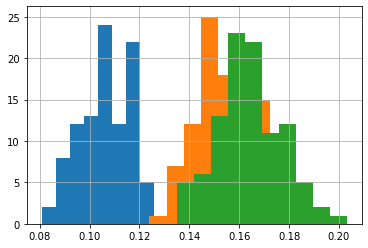

In [32]:
pd.Series(scores_svd_np).hist()
pd.Series(scores_svd_ur).hist()
pd.Series(scores_svd_ur_demeaned).hist()

In [33]:
from scipy import stats

shapiro_svd_np = stats.shapiro(scores_svd_np)
shapiro_svd_ur = stats.shapiro(scores_svd_ur)
shapiro_svd_ur_demeaned = stats.shapiro(scores_svd_ur_demeaned)

print(f'p-value svd_np: {shapiro_svd_np[1]}')
print(f'p-value svd_ur: {shapiro_svd_ur[1]}')
print(f'p-value svd_ur_demeaned: {shapiro_svd_ur_demeaned[1]}')

p-value svd_np: 0.39414629340171814
p-value svd_ur: 0.272228866815567
p-value svd_ur_demeaned: 0.6873562932014465


Тк `p-value` > 0.05, делаем вывод, что случайные величины нормально распределены.

Далее применем Т-тест для определения стат. значимости, тк эти выборки зависимые, то используем `ttest_rel`.

In [34]:
stats.ttest_rel(scores_svd_np, scores_svd_ur)

Ttest_relResult(statistic=-40.291395456702574, pvalue=3.243169086690267e-63)

In [35]:
stats.ttest_rel(scores_svd_ur, scores_svd_ur_demeaned)

Ttest_relResult(statistic=-22.431073087868118, pvalue=1.3478405587703388e-40)

Тк `pvalue < 0.05` мы можем отклонить проверяемую нулевую гипотезу о равенстве выборочных средних.

# Топ 20 для ряда испонителей

In [40]:
persons_lst = [
    281542, # The Prodigy
    56683,  # Bowie
    276125, # Pink Floyd
    200082  # Lil Wayne
]
persons[persons['person_id'].isin(persons_lst)]

,person_id,person_name,person_MBID
1373,56683,Bowie,5441c29d-3602-4898-b1a1-b77fa23b8e50
21043,276125,Pink+Floyd+&+Floyd,83d91898-7763-47d7-b03b-b92132375c47
25139,56683,David+Bowie+&+Bing+Crosby,5441c29d-3602-4898-b1a1-b77fa23b8e50
27674,56683,David+Bowie+&+Pet+Shop+Boys,5441c29d-3602-4898-b1a1-b77fa23b8e50
32700,56683,David+Bowie+&+Phillip+Glass,NaN
40008,56683,David+Bowie+&+Trent+Reznor,5441c29d-3602-4898-b1a1-b77fa23b8e50
40030,200082,Lil+Wayne+Feat.+Drake+&+Rick+Ross,NaN
44602,276125,Pink+Floyd+&+The+Orb,83d91898-7763-47d7-b03b-b92132375c47
44799,56683,David+Bowie+&+Pat+Metheny,5441c29d-3602-4898-b1a1-b77fa23b8e50
49995,56683,David+Bowie+&+Freddie+Mercury,5441c29d-3602-4898-b1a1-b77fa23b8e50


In [42]:
person_id_svd = svd_ur.le_person.transform(persons_lst)
person_id_svd

array([3621,  718, 3542, 2631])

In [74]:
# получим топы в внутренних для SVD id (т.е. координатах)
top_20_svd = [(person_id, svd_ur.search_person_nn([person_id], 20)) for person_id in person_id_svd]
top_20_svd = pd.DataFrame(top_20_svd, columns=['person_id', 'top']).explode('top')
top_20_svd['top'] = top_20_svd['top'].astype(int)
top_20_svd

,person_id,top
0,3621,1145
0,3621,561
0,3621,694
0,3621,2646
0,3621,962
...,...,...
3,2631,2921
3,2631,569
3,2631,677
3,2631,4909


In [78]:
# получим топы с исходными id
top_20 = top_20_svd.copy()
top_20['person_id'] = svd_ur.le_person.inverse_transform(top_20['person_id'])
top_20['top'] = svd_ur.le_person.inverse_transform(top_20['top'])

top_20

,person_id,top
0,281542,87347
0,281542,47301
0,281542,55071
0,281542,201331
0,281542,74637
...,...,...
3,200082,225790
3,200082,47600
3,200082,53400
3,200082,380933


In [103]:
persons_uniq = persons.copy()
persons_uniq['person_lenght'] = persons_uniq['person_name'].str.len()
persons_uniq = persons_uniq.sort_values('person_lenght')
persons_uniq = persons_uniq.groupby(['person_id'], as_index=False)['person_name'].first()
persons_uniq

,person_id,person_name
0,0,000003+Music+Instructor
1,1,00-01
2,2,0005.+Overkill
3,3,000C+Tony+Dize
4,4,000+Oscarcito
...,...,...
560922,595136,Kwajbasket+&+Gimu
560923,595137,David+Granha+&+John+Axion
560924,595138,"Tam+Cooper,+Will+Saul"
560925,595139,Cousin+Silas+&+LPF12


In [114]:
top_20_with_names = (top_20
    .merge(persons_uniq, how="left", on=['person_id'])
    .merge(persons_uniq, how="left", left_on=['top'], right_on=['person_id'], suffixes=('', '_neighbour'))
    .drop(columns=['person_id_neighbour'])
)

top_20_with_names

,person_id,top,person_name,person_name_neighbour
0,281542,87347,Prodigy,TCM
1,281542,47301,Prodigy,Big+Giant+Circles
2,281542,55071,Prodigy,Bomfunk+MCs
3,281542,201331,Prodigy,Lionrock
4,281542,74637,Prodigy,Chemical+Brothers
...,...,...,...,...
75,200082,225790,Lil+Wayne,Meek+Mill
76,200082,47600,Lil+Wayne,Big+Sean
77,200082,53400,Lil+Wayne,B.o.B
78,200082,380933,Lil+Wayne,T-Pain


### Посмотрим поближе на топ 20 по ряду исполнителей

In [115]:
# Prodigy
top_20_with_names[
    top_20_with_names['person_id'].isin([281542])
]

# Посмотрел похожие на сайте самого last.fm
# https://www.last.fm/ru/music/The+Prodigy/+similar
# 1 страница: TCM, Chemical+Brothers, Fatboy+Slim, JXL
# 2 страница: Moby, Freestylers
# 3 страница: Bomfunk+MCs

,person_id,top,person_name,person_name_neighbour
0,281542,87347,Prodigy,TCM
1,281542,47301,Prodigy,Big+Giant+Circles
2,281542,55071,Prodigy,Bomfunk+MCs
3,281542,201331,Prodigy,Lionrock
4,281542,74637,Prodigy,Chemical+Brothers
5,281542,147331,Prodigy,Fake+Blood
6,281542,253878,Prodigy,Noir+D%C3%A9sir
7,281542,148559,Prodigy,Fatboy+Slim
8,281542,436980,Prodigy,Hybrid
9,281542,235902,Prodigy,Moby


In [116]:
# Bowie
top_20_with_names[
    top_20_with_names['person_id'].isin([56683])
]

# Посмотрел похожие на сайте самого last.fm
# https://www.last.fm/ru/music/David+Bowie/+similar
# 1 страница: T+Rex, Velvet+Underground, 
# 2 страница: 
# 3 страница: 
# 4 страница: Genesis, New+Order

,person_id,top,person_name,person_name_neighbour
20,56683,297427,Bowie,Roberto+Carlos
21,56683,75323,Bowie,Chico+Buarque
22,56683,375671,Bowie,Tim+Maia
23,56683,141934,Bowie,Eric+Clapton
24,56683,41687,Bowie,B.B.King
25,56683,378157,Bowie,Tom+Jones
26,56683,374371,Bowie,Tiago+Iorc
27,56683,29575,Bowie,Aretha+Franklin
28,56683,286567,Bowie,Raffi
29,56683,86006,Bowie,Cream


In [117]:
# Pink Floyd
top_20_with_names[
    top_20_with_names['person_id'].isin([276125])
]

# Посмотрел похожие на сайте самого last.fm
# https://www.last.fm/ru/music/Pink+Floyd/+similar
# 1 страница: David+Gilmour, Doors, Yes
# 2 страница: Camel
# 3 страница: 
# 4 страница: Van+der+Graaf+Generator

,person_id,top,person_name,person_name_neighbour
40,276125,452182,Pink+Floud,Jethro+Tull
41,276125,407892,Pink+Floud,Yes
42,276125,354785,Pink+Floud,Doors
43,276125,66400,Pink+Floud,Camel
44,276125,47753,Pink+Floud,Big+Wreck
45,276125,364487,Pink+Floud,The+Pack+AD
46,276125,344133,Pink+Floud,Tangerine+Dream
47,276125,212350,Pink+Floud,Magma
48,276125,321461,Pink+Floud,Sixx:A.M.
49,276125,66695,Pink+Floud,Can


In [118]:
# Lil Wayne
top_20_with_names[
    top_20_with_names['person_id'].isin([200082])
]

# Посмотрел похожие на сайте самого last.fm
# https://www.last.fm/ru/music/Lil%27+Wayne/+similar
# 1 страница: 2+Chainz, T.I., Meek+Mill, Jeezy, Birdman
# 2 страница: Future, DJ+Khaled, Gucci+Mane, Big+Sean
# 3 страница: j.cole, Ace+Hood
# 4 страница: Ludacris, T-Pain, Wale

,person_id,top,person_name,person_name_neighbour
60,200082,161570,Lil+Wayne,Tyga
61,200082,3165,Lil+Wayne,2+Chainz
62,200082,374349,Lil+Wayne,T.I.
63,200082,397111,Lil+Wayne,Wale
64,200082,160331,Lil+Wayne,Future
65,200082,420178,Lil+Wayne,DJ+Khaled
66,200082,200037,Lil+Wayne,Lil+Jon
67,200082,408323,Lil+Wayne,Jeezy
68,200082,173505,Lil+Wayne,Gucci+Mane
69,200082,449356,Lil+Wayne,j.cole
